In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
#import cython
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [3]:
# our modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d


In [4]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

In [5]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
basedir="../LaCE_manager/LaCE/lace/emulator/sim_suites/Australia20/"
basedir_test="/LaCE/lace/emulator/sim_suites/Australia20/"

In [6]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))

## LOAD FRACTIONAL ERRORS

In [8]:
fractional_error_1axis = (np.loadtxt('fractional_errors/1_axis/fractional_error_plusminus.txt').reshape(30,11,32)-1)*100
fractional_error_3axes_1a = (np.load('fractional_errors/3_axes/fractional_error_3a_1axis.txt').reshape(30,11,32)-1)*100
fractional_error_1a_3a = (np.load('fractional_errors/3_axes/fractional_error_3a_1a.txt').reshape(30,11,32)-1)*100


In [9]:
#fractional_error_gp_1axis = np.loadtxt('notebooks_tests/fractional_error_gp.txt').reshape(30,11,32)
fractional_error_3axes_all = (np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgall.txt').reshape(30,11,32)-1)*100 #average axes
fractional_error_3axes_axes = (np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgaxes.txt').reshape(30,11,32)-1)*100 #average axes
fractional_error_3axes_phases = (np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgphases.txt').reshape(30,11,32)-1)*100 #average axes

fractional_error_3axes_axesphases = (np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgphases_avgaxes.txt').reshape(30,11,32)-1)*100 #average axes + avg phases

fractional_error_3axes_axesphasesnone = (np.loadtxt('fractional_errors/3_axes_scalings/fractional_error_avgphases_avgaxes_none.txt').reshape(30,11,32)-1)*100 #average axes


In [10]:
sigma68(fractional_error_3axes_all.flatten()), sigma68(fractional_error_3axes_axes.flatten()), sigma68(fractional_error_3axes_phases.flatten()),sigma68(fractional_error_3axes_axesphases.flatten()),sigma68(fractional_error_3axes_axesphasesnone.flatten())




(1.0203177497829543,
 1.1142918630946137,
 0.9967058397291283,
 0.9874270251480178,
 0.954860618106359)

In [11]:
labels=['1A', '3A - avg. all','3A - avg. axes', r'3A - avg. phases',r'3A-avg. axes + avg phases',r'3A - avg. axes + avg. phases + indep.']#, r'3A - avg. all + indep',r'3A - avg. axes + avg. phases + indep.']
means = np.array([np.median(fractional_error_1a_3a),np.median(fractional_error_3axes_all),np.median(fractional_error_3axes_axes),np.median(fractional_error_3axes_phases), np.median(fractional_error_3axes_axesphases),np.median(fractional_error_3axes_axesphasesnone)])
errs = np.array([sigma68(fractional_error_1a_3a.flatten()),sigma68(fractional_error_3axes_all.flatten()),sigma68(fractional_error_3axes_axes.flatten()),sigma68(fractional_error_3axes_phases.flatten()),sigma68(fractional_error_3axes_axesphases.flatten()),sigma68(fractional_error_3axes_axesphasesnone.flatten())])#,sigma68(fractional_error_3axis_axesphasesnone.flatten())])



 /tmp/ipykernel_168/2102754810.py:3: UserWarning:color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
 /tmp/ipykernel_168/2102754810.py:4: UserWarning:color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


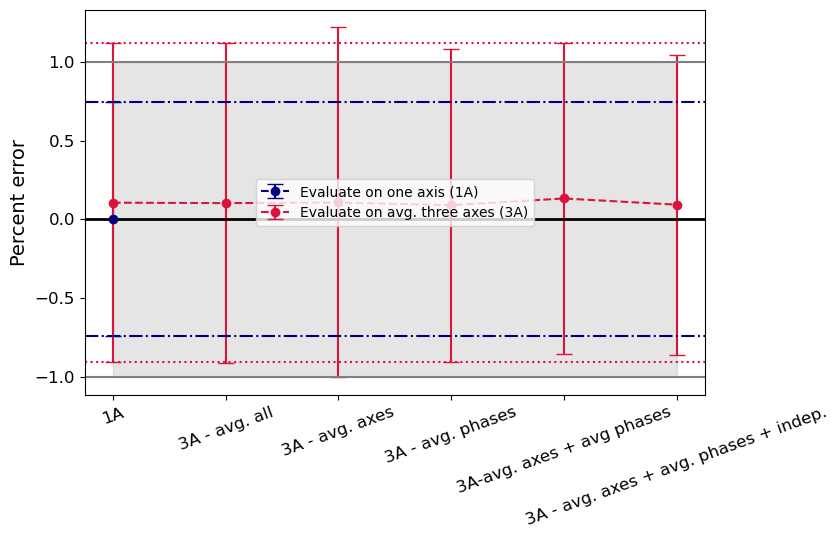

In [12]:
plt.figure(figsize = (8,5))

plt.errorbar(labels[0:1], [np.median(fractional_error_1axis)], [sigma68(fractional_error_1axis.flatten())],  color = 'navy', ls = '--',fmt='ro', capsize=6, label = 'Evaluate on one axis (1A)' )
plt.errorbar(labels, means, errs,  color = 'crimson', ls = '--',fmt='ro', capsize=6, label = 'Evaluate on avg. three axes (3A)')

plt.axhline(y=-1, color ='grey')
plt.axhline(y=1, color ='grey')
plt.fill_between(labels,-1,1, color = 'grey', alpha =0.2)

plt.axhline(y=np.median(fractional_error_1axis)-sigma68(fractional_error_1axis.flatten()), color ='navy', ls ='-.')
plt.axhline(y=np.median(fractional_error_1axis)+sigma68(fractional_error_1axis.flatten()), color ='navy', ls ='-.')

plt.axhline(y=np.median(fractional_error_1a_3a)-sigma68(fractional_error_1a_3a.flatten()), color ='crimson', ls =':')
plt.axhline(y=np.median(fractional_error_1a_3a)+sigma68(fractional_error_1a_3a.flatten()), color ='crimson', ls =':')


plt.yticks(fontsize = 12)
plt.xticks(rotation =20, fontsize = 12)

plt.ylabel('Percent error', fontsize = 14)

plt.axhline(y =0, color = 'black', lw = 2)

#info_text = 'A = Polyfit-log\nB = log(P1D)\nC = LeakyReLU\nD = Param. space shift\nE = 2 phases'
#plt.text(0.62, 0.7, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize = 14)


#plt.ylim(-2,2)

plt.legend()

plt.savefig('net_characterisation_axes.pdf', bbox_inches = 'tight')